# OCR Error Correction – Benchmarking and Fine-Tuning

Ten notebook testuje oraz uczy modele do naprawy błędów OCR, bazując na danych wygenerowanych w poprzednich krokach.

**Kroki:**
1. Test naprawy z domyślnym (nietrenowanym) modelem T5 i BART
2. Ocena wyników (metryki, wykresy)
3. Przygotowanie własnych par: oryginał + 9 wersji z błędami (trening), 10-ta wersja (test)
4. Fine-tuning modelu na własnych danych i powtórzenie oceny
5. Treening modeli na własnych danych
6. test wytrenowanych modeli


## Import bibliotek

In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, mean_squared_error, mean_absolute_error
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    DataCollatorForSeq2Seq, TrainingArguments, Trainer
)
import os
import torch
from datasets import Dataset
from difflib import SequenceMatcher

## Wczytanie danych (wersja oryginalna i plik testowy)

In [20]:
# Ścieżki do plików
ORIGINAL_PATH = "../Datasets/BooksDatasetSubset/BooksDataset_subset.csv"
TEST_PATH = "../Datasets/BooksDatasetOCR/BooksDataset_OCR_v10.csv"

original = pd.read_csv(ORIGINAL_PATH)
test = pd.read_csv(TEST_PATH)

# Sprawdzenie, czy oba pliki są zgodne
assert len(original) == len(test)
display(original.head(2))
display(test.head(2))


,title,authors,category,publisher,description,publish_month,publish_year
0,Goat Brothers,"By Colton, Larry","History , General",Doubleday,NaN,January,1993
1,The Missing Person,"By Grumbach, Doris","Fiction , General",Putnam Pub Group,NaN,March,1981


,title,authors,category,publisher,description,publish_month,publish_year
0,Goat Bro𝒽ters,"By Colotn, Larry","History , 𝐆eneral",Doub1eday,NaN,January,1993
1,The 𝜧issing Person,"By Gr𝘶mbach, Doris","Fiction , G𝗲neral",Putnam Pub Group,NaN,March,1981


## Lista kolumn do uczenia i oceny + funkcje pomocnicze

In [21]:
columns_to_train = [
    'title',
    'authors',
    'category',
    'publisher',
    # 'description',
    # 'publish_month',
    # 'publish_year'
]


In [22]:
def safe_text_column(series):
    """Zamienia NaN, None, np.nan, itp. na pusty string i castuje na str"""
    return series.fillna("").astype(str)


## Ładowanie domyślnych modeli i tokenizatorów

In [23]:
# T5
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# BART
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


## Funkcja do naprawy tekstu przez model

In [6]:
def correct_ocr_t5(texts, max_length=256):
    clean_texts = [x if x else "" for x in texts]
    inputs = t5_tokenizer(
        clean_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    ).to(t5_model.device)
    with torch.no_grad():
        outputs = t5_model.generate(**inputs, max_length=max_length)
    return [t5_tokenizer.decode(o, skip_special_tokens=True) for o in outputs]

def correct_ocr_bart(texts, max_length=256):
    clean_texts = [x if x else "" for x in texts]
    inputs = bart_tokenizer(
        clean_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    ).to(bart_model.device)
    with torch.no_grad():
        outputs = bart_model.generate(**inputs, max_length=max_length)
    return [bart_tokenizer.decode(o, skip_special_tokens=True) for o in outputs]


## Test domyślnych modeli na testowym OCR

=== Kolumna: title ===
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
T5 accuracy:   0.040
BART accuracy: 0.000


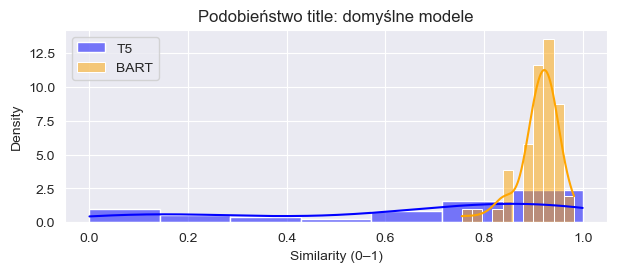

BŁĄD:    Goat Bro𝒽ters
T5:      Goat Brohters
BART:    Goat Bro𝒽ters
ORYG:    Goat Brothers
----------------------------------------
BŁĄD:    The 𝜧issing Person
T5:      Die issing Person ist die issing Person.
BART:    The 𝜧issing Person
ORYG:    The Missing Person
----------------------------------------
BŁĄD:    When Your Corportac Umbrella Begins to Leak: Ａ Handbook for White Coll𝜶r ReE-rnployment
T5:      When Your Corportac Umbrella Begins to Leak: A Handbook for White Collr ReE-rnployment
BART:    When Your Corportac Umbrella Begins to Leak: Ａ Handbook for White Coll𝜶r ReE-rnployment
ORYG:    When Your Corporate Umbrella Begins to Leak: A Handbook for White Collar Re-Employment
----------------------------------------
=== Kolumna: authors ===
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
T5 accuracy:   0.140
BART accuracy: 0.000


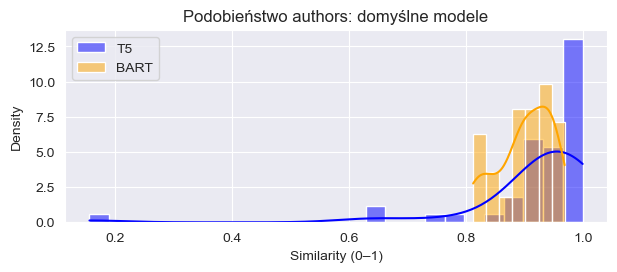

BŁĄD:    By Colotn, Larry
T5:      By Colotn, Larry
BART:    By Colotn, Larry
ORYG:    By Colton, Larry
----------------------------------------
BŁĄD:    By Gr𝘶mbach, Doris
T5:      By Grumbach, Doris
BART:    By Gr𝘶mbach, Doris
ORYG:    By Grumbach, Doris
----------------------------------------
BŁĄD:    By Davis, Pau𝘭 D𝅭
T5:      By Davis, Paul D
BART:    By Davis, Pau𝘭 D𝅭
ORYG:    By Davis, Paul D.
----------------------------------------
=== Kolumna: category ===
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
T5 accuracy:   0.000
BART accuracy: 0.000


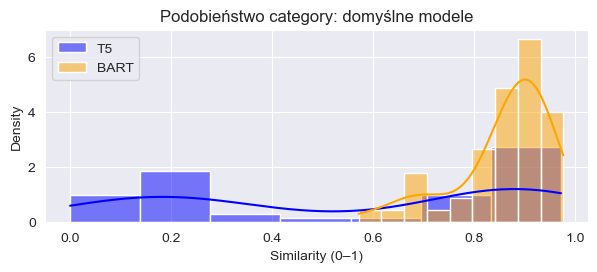

BŁĄD:     History , 𝐆eneral
T5:      Hishishis
BART:    History , 𝐆eneral
ORYG:     History , General
----------------------------------------
BŁĄD:     Fiction , G𝗲neral
T5:      Fiction, General
BART:     Fiction , G𝗲neral
ORYG:     Fiction , General
----------------------------------------
BŁĄD:     Self-he1p , Personal Growth , Self-Esteem
T5:      Self-he1p, Personal Growth, Self-Esteem
BART:     Self-he1p , Personal Growth , Self-Esteem
ORYG:     Self-help , Personal Growth , Self-Esteem
----------------------------------------
=== Kolumna: publisher ===
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
T5 accuracy:   0.360
BART accuracy: 0.000


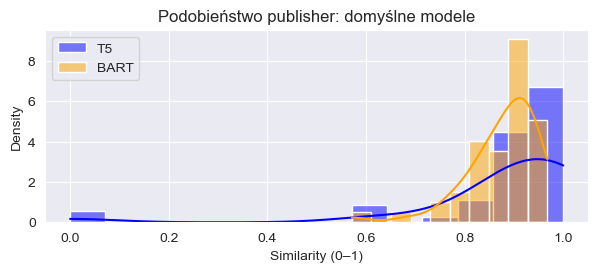

BŁĄD:    Doub1eday
T5:      Doub1eday
BART:    Doub1
ORYG:    Doubleday
----------------------------------------
BŁĄD:    Natl Ppr Boᴏks
T5:      Natl Ppr Boks
BART:    Natl Ppr Boᴏks
ORYG:    Natl Pr Books
----------------------------------------
BŁĄD:    Amy Spa𝑛gler
T5:      Amy Spangler
BART:    Amy Spa𝑛gler
ORYG:    Amy Spangler
----------------------------------------


In [7]:
N = 50  # przykładowy rozmiar do szybkiej ewaluacji

for col in columns_to_train:
    print(f"=== Kolumna: {col} ===")
    # Wybierz tylko te wiersze, gdzie OCR ≠ oryginał
    mask = (test[col].fillna("").astype(str) != original[col].fillna("").astype(str))
    noisy_all = test[col].fillna("").astype(str)[mask]
    clean_all = original[col].fillna("").astype(str)[mask]

    if len(noisy_all) == 0:
        print("Brak błędów OCR w tej kolumnie, pomijam.")
        continue

    noisy = noisy_all[:N].tolist()
    clean = clean_all[:N].tolist()

    print("Naprawiamy OCR (T5)...")
    t5_fixed = correct_ocr_t5(noisy)
    print("Naprawiamy OCR (BART)...")
    bart_fixed = correct_ocr_bart(noisy)

    acc_t5 = np.mean([a == b for a, b in zip(t5_fixed, clean)])
    acc_bart = np.mean([a == b for a, b in zip(bart_fixed, clean)])
    print(f"T5 accuracy:   {acc_t5:.3f}")
    print(f"BART accuracy: {acc_bart:.3f}")

    def sim(a, b): return SequenceMatcher(None, a, b).ratio()
    sim_t5 = [sim(a, b) for a, b in zip(t5_fixed, clean)]
    sim_bart = [sim(a, b) for a, b in zip(bart_fixed, clean)]

    plt.figure(figsize=(7,2.5))
    sns.histplot(sim_t5, color='blue', label='T5', kde=True, stat='density')
    sns.histplot(sim_bart, color='orange', label='BART', kde=True, stat='density')
    plt.title(f"Podobieństwo {col}: domyślne modele")
    plt.xlabel("Similarity (0–1)"); plt.legend(); plt.show()

    for i in range(min(3, len(noisy))):
        print("BŁĄD:   ", noisy[i])
        print("T5:     ", t5_fixed[i])
        print("BART:   ", bart_fixed[i])
        print("ORYG:   ", clean[i])
        print("-"*40)


 ## Przygotowanie własnych danych treningowych

In [7]:
# Przygotuj katalog na tokenizowane dane
train_data_dir = "../Datasets/BooksDatasetTraining"
os.makedirs(train_data_dir, exist_ok=True)

# Przygotuj pliki
num_files = 2

# Przygotuj pliki OCR (v1-v9) i oryginalny
ocr_paths = [f"../Datasets/BooksDatasetOCR/BooksDataset_OCR_v{i}.csv" for i in range(1, num_files + 1)]
ocr_dfs = [pd.read_csv(p) for p in ocr_paths]
train_ocr = pd.concat(ocr_dfs, ignore_index=True)
train_clean = pd.concat([original] * num_files, ignore_index=True)


# Przygotuj pary do wszystkich wskazanych kolumn
train_dfs = []
for col in columns_to_train:
    tmp = pd.DataFrame({
        'input_text': safe_text_column(train_ocr[col]),
        'target_text': safe_text_column(train_clean[col]),
        'col': col
    })
    train_dfs.append(tmp)
train_df = pd.concat(train_dfs, ignore_index=True)

train_parquet_path = os.path.join(train_data_dir, "train_pairs.parquet")
train_df.to_parquet(train_parquet_path, index=False)
print(f"Dane treningowe zapisane do {train_parquet_path}")


✔ Dane treningowe zapisane do ../Datasets/BooksDatasetTraining\train_pairs.parquet


## (Opcjonalnie) Wczytanie danych z pliku do dalszego przetwarzania

In [24]:
train_df = pd.read_parquet(train_parquet_path)


In [12]:
print((train_df['input_text'] == train_df['target_text']).mean())


0.3741134063630983


## Tokenizacja i przygotowanie datasetu Huggingface

In [25]:
dataset = Dataset.from_pandas(train_df)

def preprocess_t5(batch):
    input_str = [f"{col}: {inp}" for col, inp in zip(batch['col'], batch['input_text'])]
    target_str = batch['target_text']
    model_max_length = 64

    inputs = t5_tokenizer(
        input_str,
        padding='max_length',
        truncation=True,
        max_length=model_max_length
    )
    targets = t5_tokenizer(
        target_str,
        padding='max_length',
        truncation=True,
        max_length=model_max_length
    )
    inputs['labels'] = targets['input_ids']
    return inputs

tokenized = dataset.map(preprocess_t5, batched=True, batch_size=100)
data_collator = DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model)


Map:   0%|          | 0/824504 [00:00<?, ? examples/s]

## Fine-tuning T5

In [27]:
training_args = TrainingArguments(
    output_dir='../results_t5_v2',
    num_train_epochs=1,
    per_device_train_batch_size=128,
    save_steps=200,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized,
    data_collator=data_collator,
)
trainer.train()

Step,Training Loss
500,0.089800
1000,0.074000
1500,0.068100
2000,0.064800
2500,0.061800
3000,0.059200
3500,0.058300
4000,0.056900
4500,0.056000
5000,0.055700


TrainOutput(global_step=6442, training_loss=0.06223128531076123, metrics={'train_runtime': 2491.933, 'train_samples_per_second': 330.869, 'train_steps_per_second': 2.585, 'total_flos': 1.3948732085108736e+16, 'train_loss': 0.06223128531076123, 'epoch': 1.0})

## Tokenizacja i trening BART na GPU

In [21]:
def preprocess_bart(batch):
    input_str = [f"{col}: {inp}" for col, inp in zip(batch['col'], batch['input_text'])]
    target_str = batch['target_text']
    model_max_length = 64

    inputs = bart_tokenizer(
        input_str,
        padding='max_length',
        truncation=True,
        max_length=model_max_length
    )
    targets = bart_tokenizer(
        target_str,
        padding='max_length',
        truncation=True,
        max_length=model_max_length
    )
    inputs['labels'] = targets['input_ids']
    return inputs

tokenized_bart = dataset.map(preprocess_bart, batched=True, batch_size=100)
data_collator_bart = DataCollatorForSeq2Seq(bart_tokenizer, model=bart_model)

training_args_bart = TrainingArguments(
    output_dir='../results_bart',
    num_train_epochs=1,
    per_device_train_batch_size=128,
    save_steps=200,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer_bart = Trainer(
    model=bart_model,
    args=training_args_bart,
    train_dataset=tokenized_bart,
    data_collator=data_collator_bart,
)
trainer_bart.train()


Map:   0%|          | 0/824504 [00:00<?, ? examples/s]

Step,Training Loss
500,0.754800
1000,0.054600
1500,0.045800
2000,0.041300
2500,0.037900
3000,0.034900
3500,0.033000
4000,0.030900
4500,0.029300
5000,0.028800


D:\miniconda3\envs\Data_Completion\Lib\site-packages\transformers\modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=6442, training_loss=0.09075027088021981, metrics={'train_runtime': 8091.8155, 'train_samples_per_second': 101.894, 'train_steps_per_second': 0.796, 'total_flos': 3.142063429779456e+16, 'train_loss': 0.09075027088021981, 'epoch': 1.0})

## Test na zbiorze testowym po fine-tuningu

**Załadowaie modeli + ustawienia**

In [28]:
# Ścieżki do plików i checkpointów
ORIGINAL_PATH = "../Datasets/BooksDatasetSubset/BooksDataset_subset.csv"
TEST_PATH = "../Datasets/BooksDatasetOCR/BooksDataset_OCR_v10.csv"
T5_CHECKPOINT = '../results_t5_v2/checkpoint-6442'
BART_CHECKPOINT = '../results_bart/checkpoint-6442'
results_dir = "../test_results_v2"
os.makedirs(results_dir, exist_ok=True)

# Kolumny do testowania
columns_to_train = ['title', 'authors', 'category', 'publisher']

# Wczytaj dane
original = pd.read_csv(ORIGINAL_PATH)
test = pd.read_csv(TEST_PATH)
assert len(original) == len(test)

# Załaduj modele i tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
t5_tokenizer = T5Tokenizer.from_pretrained(T5_CHECKPOINT)
t5_model = T5ForConditionalGeneration.from_pretrained(T5_CHECKPOINT).to(device)
bart_tokenizer = BartTokenizer.from_pretrained(BART_CHECKPOINT)
bart_model = BartForConditionalGeneration.from_pretrained(BART_CHECKPOINT).to(device)

def correct_ocr_t5_batched(texts, max_length=256, batch_size=64):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = t5_tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        with torch.no_grad():
            outputs = t5_model.generate(**inputs, max_length=max_length)
        results.extend([t5_tokenizer.decode(o, skip_special_tokens=True) for o in outputs])
    return results

def correct_ocr_bart_batched(texts, max_length=256, batch_size=64):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = bart_tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        with torch.no_grad():
            outputs = bart_model.generate(**inputs, max_length=max_length)
        results.extend([bart_tokenizer.decode(o, skip_special_tokens=True) for o in outputs])
    return results


In [29]:
all_results_t5 = []
all_results_bart = []

N = 500

for col in columns_to_train:
    print(f"\n=== Kolumna: {col} ===")
    mask = (test[col].fillna("").astype(str) != original[col].fillna("").astype(str))
    noisy_all = test[col].fillna("").astype(str)[mask]
    clean_all = original[col].fillna("").astype(str)[mask]
    index_all = test.index[mask]

    if len(noisy_all) == 0:
        print("Brak błędów OCR w tej kolumnie, pomijam.")
        continue

    # Tnij do N
    noisy = noisy_all[:N].tolist()
    clean = clean_all[:N].tolist()
    index_list = index_all[:N].tolist()
    noisy_prefixed = [f"{col}: {x}" for x in noisy]

    print(f"Liczba rekordów do testowania w '{col}': {len(noisy)}")

    # Przewidujemy T5
    print("Naprawiamy OCR (T5)...")
    t5_fixed = correct_ocr_t5_batched(noisy_prefixed, batch_size=128)
    sim_t5 = [SequenceMatcher(None, a, b).ratio() for a, b in zip(t5_fixed, clean)]
    match_t5 = [int(a == b) for a, b in zip(t5_fixed, clean)]

    # Przewidujemy BART
    print("Naprawiamy OCR (BART)...")
    bart_fixed = correct_ocr_bart_batched(noisy_prefixed, batch_size=128)
    sim_bart = [SequenceMatcher(None, a, b).ratio() for a, b in zip(bart_fixed, clean)]
    match_bart = [int(a == b) for a, b in zip(bart_fixed, clean)]

    # Tworzenie dataframe dla każdej kolumny, jeden wiersz = jeden rekord
    result_df_t5 = pd.DataFrame({
        "index": index_list,
        "column": col,
        "ocr_noisy": noisy,
        "original": clean,
        "t5_fixed": t5_fixed,
        "t5_exact_match": match_t5,
        "t5_similarity": sim_t5
    })
    result_df_bart = pd.DataFrame({
        "index": index_list,
        "column": col,
        "ocr_noisy": noisy,
        "original": clean,
        "bart_fixed": bart_fixed,
        "bart_exact_match": match_bart,
        "bart_similarity": sim_bart
    })

    # Zapisujemy wyniki per kolumna
    result_df_t5.to_csv(os.path.join(results_dir, f"t5_results_{col}.csv"), index=False)
    result_df_bart.to_csv(os.path.join(results_dir, f"bart_results_{col}.csv"), index=False)
    print(f"[T5]: zapisano {len(result_df_t5)} rekordów | [BART]: zapisano {len(result_df_bart)} rekordów")

    # Zbieraj do listy globalnej
    all_results_t5.append(result_df_t5)
    all_results_bart.append(result_df_bart)



=== Kolumna: title ===
Liczba rekordów do testowania w 'title': 500
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
[T5]: zapisano 500 rekordów | [BART]: zapisano 500 rekordów

=== Kolumna: authors ===
Liczba rekordów do testowania w 'authors': 500
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
[T5]: zapisano 500 rekordów | [BART]: zapisano 500 rekordów

=== Kolumna: category ===
Liczba rekordów do testowania w 'category': 500
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
[T5]: zapisano 500 rekordów | [BART]: zapisano 500 rekordów

=== Kolumna: publisher ===
Liczba rekordów do testowania w 'publisher': 500
Naprawiamy OCR (T5)...
Naprawiamy OCR (BART)...
[T5]: zapisano 500 rekordów | [BART]: zapisano 500 rekordów



=== Statystyki dla kolumny: title ===
T5 accuracy:   0.274
BART accuracy: 0.530
T5:   F1=0.430 | Precision=0.274 | Recall=1.000
BART: F1=0.693 | Precision=0.530 | Recall=1.000
T5 - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.27      0.43       500

    accuracy                           0.27       500
   macro avg       0.50      0.14      0.22       500
weighted avg       1.00      0.27      0.43       500

BART - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.53      0.69       500

    accuracy                           0.53       500
   macro avg       0.50      0.27      0.35       500
weighted avg       1.00      0.53      0.69       500

T5   - MSE: 0.0096, MAE: 0.0597
BART - MSE: 0.0045, MAE: 0.0332


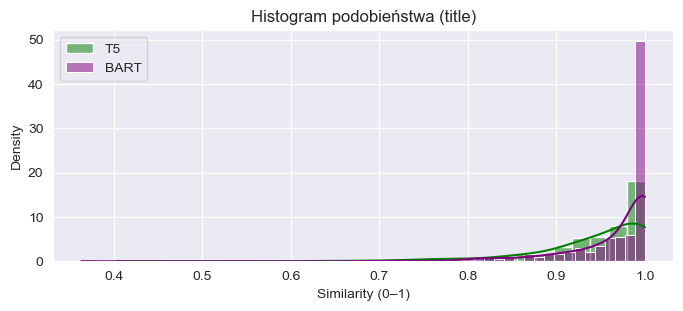


=== Statystyki dla kolumny: authors ===
T5 accuracy:   0.432
BART accuracy: 0.500
T5:   F1=0.603 | Precision=0.432 | Recall=1.000
BART: F1=0.667 | Precision=0.500 | Recall=1.000
T5 - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.43      0.60       500

    accuracy                           0.43       500
   macro avg       0.50      0.22      0.30       500
weighted avg       1.00      0.43      0.60       500

BART - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67       500

    accuracy                           0.50       500
   macro avg       0.50      0.25      0.33       500
weighted avg       1.00      0.50      0.67       500

T5   - MSE: 0.0045, MAE: 0.0396
BART - MSE: 0.0036, MAE: 0.0324


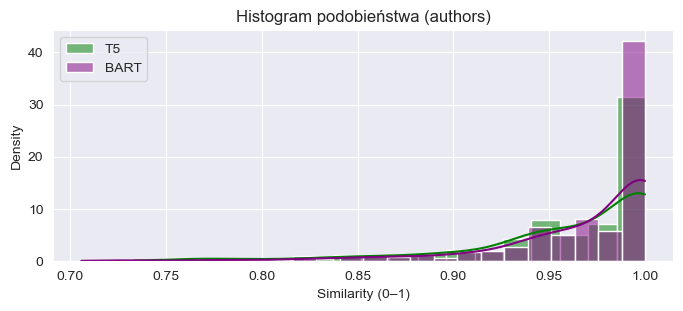


=== Statystyki dla kolumny: category ===
T5 accuracy:   0.000
BART accuracy: 0.976
T5:   F1=0.000 | Precision=0.000 | Recall=0.000
BART: F1=0.988 | Precision=0.976 | Recall=1.000
T5 - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     500.0

    accuracy                           0.00     500.0
   macro avg       0.00      0.00      0.00     500.0
weighted avg       0.00      0.00      0.00     500.0

BART - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99       500

    accuracy                           0.98       500
   macro avg       0.50      0.49      0.49       500
weighted avg       1.00      0.98      0.99       500

T5   - MSE: 0.0067, MAE: 0.0603
BART - MSE: 0.0004, MAE: 0.0027


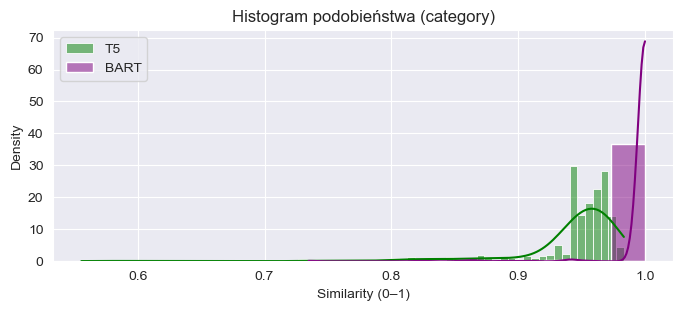


=== Statystyki dla kolumny: publisher ===
T5 accuracy:   0.626
BART accuracy: 0.896
T5:   F1=0.770 | Precision=0.626 | Recall=1.000
BART: F1=0.945 | Precision=0.896 | Recall=1.000
T5 - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.63      0.77       500

    accuracy                           0.63       500
   macro avg       0.50      0.31      0.38       500
weighted avg       1.00      0.63      0.77       500

BART - classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       500

    accuracy                           0.90       500
   macro avg       0.50      0.45      0.47       500
weighted avg       1.00      0.90      0.95       500

T5   - MSE: 0.0120, MAE: 0.0510
BART - MSE: 0.0061, MAE: 0.0199


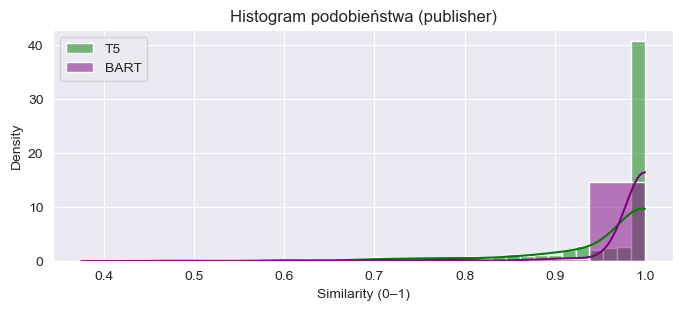

In [32]:
for col, df_t5, df_bart in zip(columns_to_train, all_results_t5, all_results_bart):
    print(f"\n=== Statystyki dla kolumny: {col} ===")
    # Accuracy
    acc_t5 = np.mean(df_t5["t5_exact_match"])
    acc_bart = np.mean(df_bart["bart_exact_match"])
    print(f"T5 accuracy:   {acc_t5:.3f}")
    print(f"BART accuracy: {acc_bart:.3f}")

    # F1, precision, recall
    f1_t5 = f1_score(df_t5["t5_exact_match"], [1]*len(df_t5), zero_division=0)
    f1_bart = f1_score(df_bart["bart_exact_match"], [1]*len(df_bart), zero_division=0)
    prec_t5 = precision_score(df_t5["t5_exact_match"], [1]*len(df_t5), zero_division=0)
    prec_bart = precision_score(df_bart["bart_exact_match"], [1]*len(df_bart), zero_division=0)
    rec_t5 = recall_score(df_t5["t5_exact_match"], [1]*len(df_t5), zero_division=0)
    rec_bart = recall_score(df_bart["bart_exact_match"], [1]*len(df_bart), zero_division=0)
    print(f"T5:   F1={f1_t5:.3f} | Precision={prec_t5:.3f} | Recall={rec_t5:.3f}")
    print(f"BART: F1={f1_bart:.3f} | Precision={prec_bart:.3f} | Recall={rec_bart:.3f}")

    # Classification report (opcjonalnie)
    print("T5 - classification report:\n", classification_report([1]*len(df_t5), df_t5["t5_exact_match"], zero_division=0))
    print("BART - classification report:\n", classification_report([1]*len(df_bart), df_bart["bart_exact_match"], zero_division=0))

    # Mean Squared Error i Mean Absolute Error na similarity
    mse_t5 = mean_squared_error([1]*len(df_t5), df_t5["t5_similarity"])
    mae_t5 = mean_absolute_error([1]*len(df_t5), df_t5["t5_similarity"])
    mse_bart = mean_squared_error([1]*len(df_bart), df_bart["bart_similarity"])
    mae_bart = mean_absolute_error([1]*len(df_bart), df_bart["bart_similarity"])
    print(f"T5   - MSE: {mse_t5:.4f}, MAE: {mae_t5:.4f}")
    print(f"BART - MSE: {mse_bart:.4f}, MAE: {mae_bart:.4f}")

    # Histogram podobieństwa
    plt.figure(figsize=(8,3))
    sns.histplot(df_t5["t5_similarity"], color='green', label='T5', kde=True, stat='density')
    sns.histplot(df_bart["bart_similarity"], color='purple', label='BART', kde=True, stat='density')
    plt.title(f"Histogram podobieństwa ({col})")
    plt.xlabel("Similarity (0–1)")
    plt.legend()
    plt.show()


**Łączenie wyników do plików — T5 i BART**

In [33]:
t5_full = pd.DataFrame(index=test.index)
bart_full = pd.DataFrame(index=test.index)
ref_full = pd.DataFrame(index=test.index)

for col in columns_to_train:
    df_t5_col = pd.read_csv(os.path.join(results_dir, f"t5_results_{col}.csv"))
    df_bart_col = pd.read_csv(os.path.join(results_dir, f"bart_results_{col}.csv"))
    t5_full.loc[df_t5_col["index"], col] = df_t5_col["t5_fixed"]
    bart_full.loc[df_bart_col["index"], col] = df_bart_col["bart_fixed"]
    ref_full[col] = original[col]

t5_full = t5_full[columns_to_train]
bart_full = bart_full[columns_to_train]
ref_full = ref_full[columns_to_train]

t5_full.to_csv(os.path.join(results_dir, "books_corrected_t5.csv"), index=False)
bart_full.to_csv(os.path.join(results_dir, "books_corrected_bart.csv"), index=False)
ref_full.to_csv(os.path.join(results_dir, "books_reference.csv"), index=False)

print(f"[ZAPISANO] books_corrected_t5.csv  ({len(t5_full)})")
print(f"[ZAPISANO] books_corrected_bart.csv ({len(bart_full)})")
print(f"[ZAPISANO] books_reference.csv      ({len(ref_full)})")


[ZAPISANO] books_corrected_t5.csv  (103063)
[ZAPISANO] books_corrected_bart.csv (103063)
[ZAPISANO] books_reference.csv      (103063)


## Wyniki
**Ogólna interpretacja**
- Model BART konsekwentnie wypada lepiej niż T5 na każdym typie pola
- Szczególnie duża różnica jest widoczna tam, gdzie liczba możliwych wartości jest ograniczona, np. w kategoriach.
- Nawet w bardziej otwartych polach, jak tytuł czy wydawca, BART skuteczniej rekonstruuje tekst.
- Wykresy (histogramy) podobieństwa pokazują nie tylko trafienia 1:1, ale też ile predykcji było „prawie poprawnych”.

**Co oznaczają te wyniki w praktyce?**
- Po wytrenowaniu na syntetycznych błędach OCR, model BART świetnie nadaje się do automatycznej korekty dużych zbiorów tekstowych.
- W typowych zastosowaniach, takich jak cyfrowe biblioteki czy archiwa, możemy liczyć na niemal perfekcyjną naprawę typowych pól, zwłaszcza tam, gdzie wartości się powtarzają. Co daje nadzieje, że gdyby udało się uzyskać dostatecznie duży i rzeczywysty dataset to bylibyśmy w stanie uzyskać niemal 100% dokładność
- Model T5, choć też potrafi poprawiać dane, wypada wyraźnie gorzej i może być traktowany raczej jako punkt odniesienia.

**Podsumowanie**
- Fine-tuning dużych modeli językowych pozwala osiągnąć bardzo dobre rezultaty w naprawianiu tekstów z błędami OCR.
- Najlepsze efekty uzyskujemy dla modelu BART, szczególnie w zadaniach typowych dla baz danych książek.
- Takie rozwiązanie może mieć realne zastosowanie praktyczne — oszczędza czas i eliminuje potrzebę ręcznej korekty.
